In [1]:
import numpy as np
import pandas as pd

import sklearn as sk

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold

In [2]:

ratings_table = pd.read_csv(filepath_or_buffer='./ml-1m/ratings.dat',
                            sep='::', delimiter=None, header=0, engine='python')

# 1.
mean_rating_global = ratings_table['Rating'].mean()
# 2.
mean_rating_per_movie = ratings_table.groupby('MovieID')['Rating'].mean()
# .3
mean_rating_per_user = ratings_table.groupby('UserID')['Rating'].mean()


def generate_X_set(columns, *features):
    matrix = np.vstack(features[:2]).T
    X_set = pd.DataFrame(data=matrix, columns=columns)
    return X_set
    
X = generate_X_set(['UserID', 'MovieID'],*[ratings_table['UserID'], ratings_table['MovieID']])

X_per_movie = generate_X_set(['MovieID', 'UserID'],*[ratings_table['UserID'], ratings_table['MovieID'], mean_rating_per_movie])


In [3]:
X_global = X.copy()

X_global['global_average'] = mean_rating_global

X_per_user = pd.merge(left=X, right=mean_rating_per_user, how='left', 
              left_on='UserID', right_index=True)

X_per_movie = pd.merge(left=X, right=mean_rating_per_movie, how='left', 
              left_on='MovieID', right_index=True)

X_per_user_and_movie = pd.merge(left=X_per_user, right=mean_rating_per_movie, how='left', 
              left_on='MovieID', right_index=True)

y = ratings_table['Rating']

In [4]:
from re import T
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def k_fold_split_training(X, y, intercept=False): 
    
    kf = KFold(n_splits=5, shuffle=True, random_state=32)
    rmse = []
    for train_index, test_index in kf.split(X):
    
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        linear_reg = LinearRegression(fit_intercept=intercept)

        linear_reg.fit(X_train, y_train)
        
        y_predict = linear_reg.predict(X_test)

        rmse.append(np.sqrt(mean_squared_error(y_test, y_predict)))
        # The mean squared error
        print("Mean squared error: %.3f" % mean_squared_error(y_test, y_predict))
        # The root mean squared error
        print("Root mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test, y_predict)))
        # The mean absolute error
        print("Mean absolute error: %.3f" % mean_absolute_error(y_test, y_predict))
        # The coefficient of determination: 1 is perfect prediction
        print("Coefficient of determination: %.3f" % r2_score(y_test, y_predict))
        
        
    return rmse


In [ ]:
total_rmses = []

total_rmses.append(k_fold_split_training(X_global, y))
total_rmses.append(k_fold_split_training(X_per_user, y))
total_rmses.append(k_fold_split_training(X_per_movie, y))
total_rmses.append(k_fold_split_training(X_per_user_and_movie, y))
total_rmses.append(k_fold_split_training(X_per_user_and_movie, y, True))

total_rmses = np.array(total_rmses)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

plt.boxplot(total_rmses.T, labels=[
            'global', 'per_user', 'per_movie', 'per_user_movie', 'per_user_movie_inter'])
plt.show()


In [32]:
df = ratings_table.drop('Timestamp', axis=1)



,MovieID,UserID
0,1193,1
1,661,1
2,914,1
3,3408,1
4,2355,1
...,...,...
1000204,1091,6040
1000205,1094,6040
1000206,562,6040
1000207,1096,6040


Text(0.5, 1.0, 'PCA projection of Movie Ratings')

Error in callback <function _draw_all_if_interactive at 0x000001A5E96B13F0> (for post_execute):


KeyboardInterrupt: 

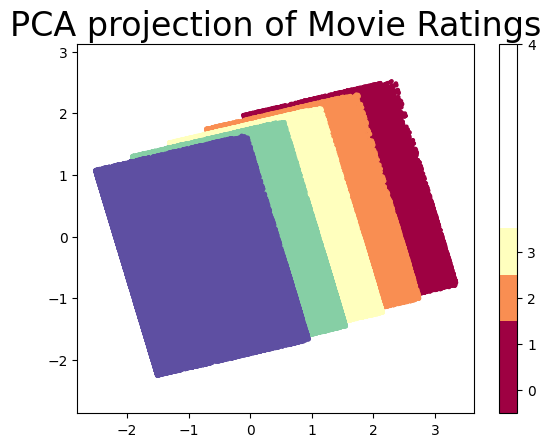

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)


pca = PCA(n_components=2)
pca.fit(scaled_data)


x_pca = pca.fit_transform(scaled_data)


plt.scatter(x_pca[:, 0], x_pca[:, 1], c=np.array(ratings_table[['Rating']]), cmap='Spectral', s=5) #c = correct prediction
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('PCA projection of Movie Ratings', fontsize=24)


In [29]:
import umap
import seaborn as sns


reducer = umap.UMAP()

embedding = reducer.fit_transform(ratings_table[['UserID', 'MovieID']])

plt.scatter(embedding[:, 0], embedding[:, 1], c=ratings_table[['Rating']], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection of the Digits dataset', fontsize=24)

KeyboardInterrupt: 

In [1]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=3, learning_rate='auto', init='random',
                  perplexity=3).fit_transform(ratings_table[['UserID', 'MovieID', 'Rating']])

plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=ratings_table[['Rating']], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('TSNE projection of the Digits dataset', fontsize=24)


NameError: name 'ratings_table' is not defined

In [2]:
def post_process_data(predictions):
    predictions[predictions > 5] = 5
    predictions[predictions < 1] = 1
    
    return predictions
    
array = np.array([[0,2,3,4,5], [1,2,3,4,6]])

array = post_process_data(array)

array

TypeError: '>' not supported between instances of 'list' and 'int'